# Importing the packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
train.csv                     63.4MB
sample_submission.csv         22.35MB
test.csv                      314.02MB


# Look at the data / Data head

In [2]:
df_train = pd.read_csv('../input/train.csv',nrows=100000)
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are given a minimal number of data fields here, consisting of:

**`id`:** Looks like a simple rowID    
**`qid{1, 2}`:** The unique ID of each question in the pair    
**`question{1, 2}`:** The actual textual contents of the questions.    
**`is_duplicate`:** The **label** that we are trying to predict - whether the two questions are duplicates of each other.

Total number of question pairs for training: 100000
Duplicate pairs: 37.25%
Total number of questions in the training data: 165931
Number of questions that appear multiple times: 19446



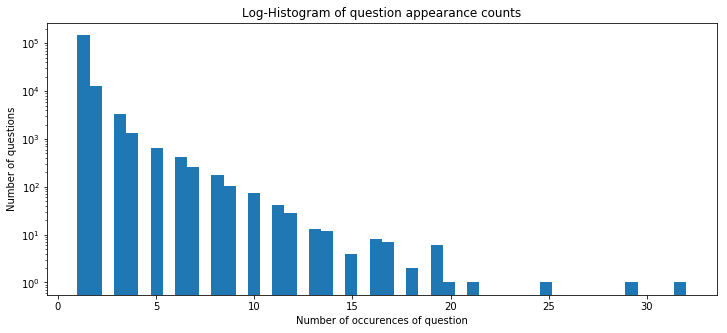

In [3]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [4]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

Predicted score: 0.6602936856809299


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Probability')

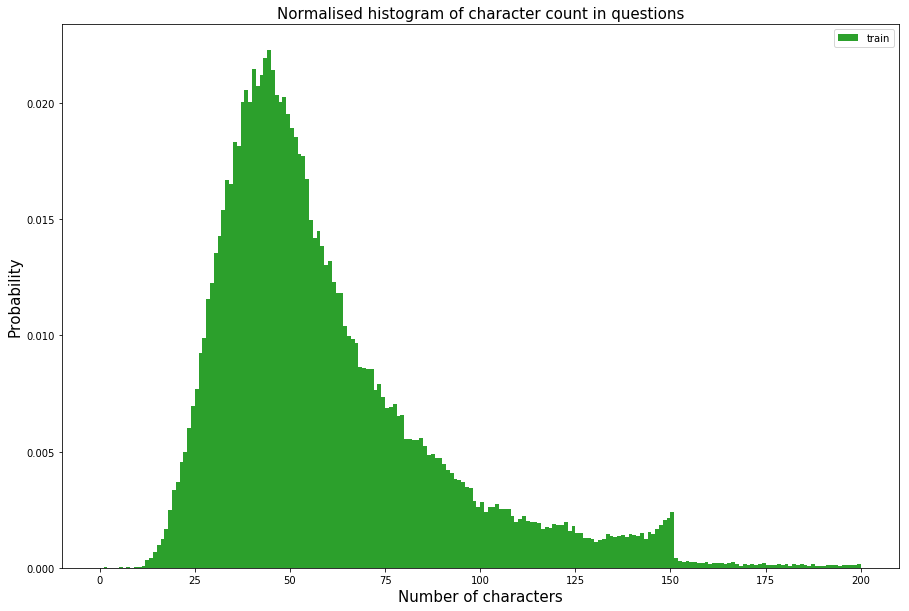

In [5]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

It can be seen that most questions have 15 to 150 characters in them. One thing that catches our eyes is the steep cut-off at 150 characters for the training set, for most questions. This could be some sort of Quora question size limit.


Similarly, we have also plotted the word count. In order to split the words, we have used a naive method i.e. splitting on spaces instead of using a serious tokenizer. This method would give us a good idea of the distribution.


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Probability')

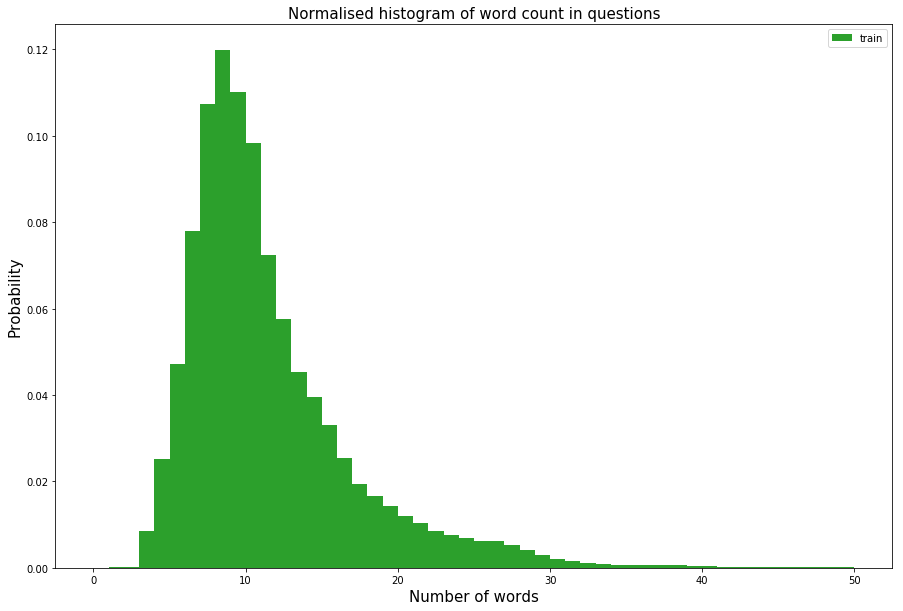

In [6]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
# dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

We see a similar distribution for word count as that of character count. It can be seen that most questions are about 10 words long. It looks that the distribution of the data is pointy. 

# Word Cloud

(-0.5, 1439.5, 1079.5, -0.5)

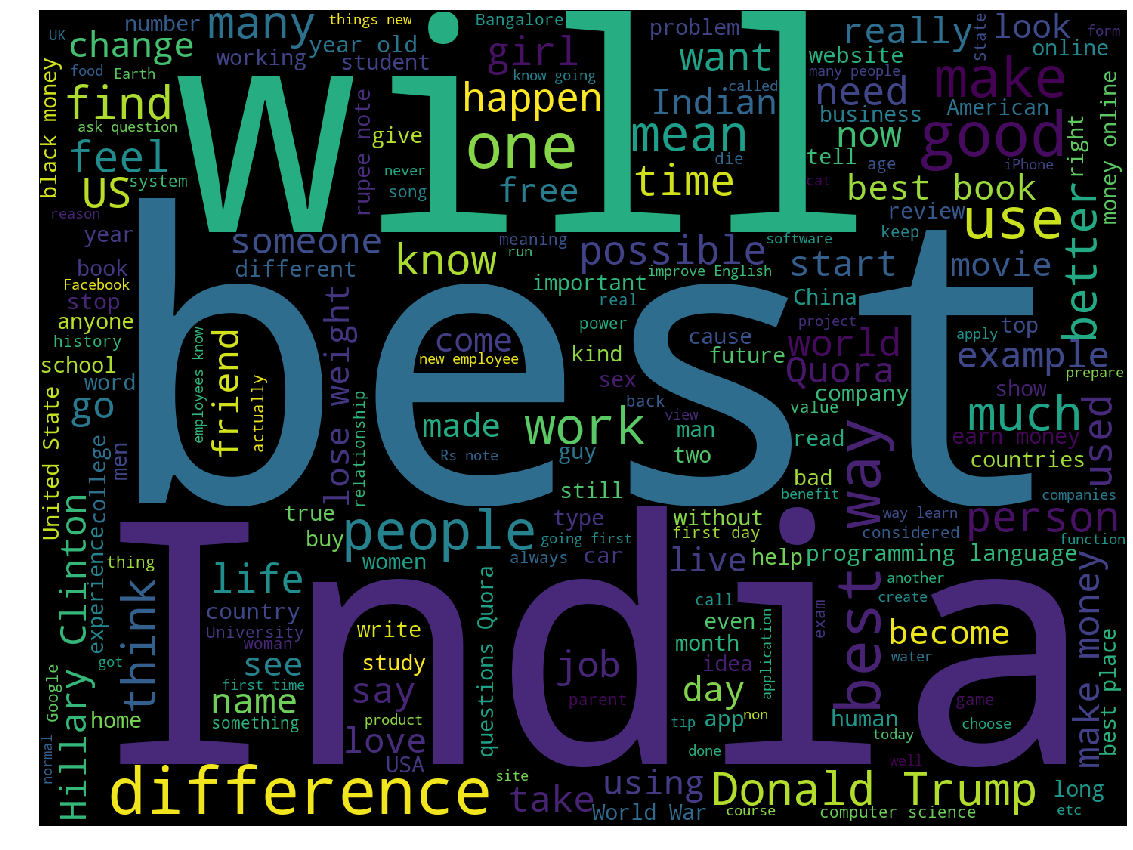

In [7]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# Semantic Analysis

Now, lets take a look at usage of different punctuations in questions - this may form a basis for some interesting features later on.

In [8]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.88%
Questions with [math] tags: 0.11%
Questions with full stops: 6.37%
Questions with capitalised first letters: 99.83%
Questions with capital letters: 99.95%
Questions with numbers: 11.75%


# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. We will start off with the word share feature from the benchmark model.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'word_match_share')

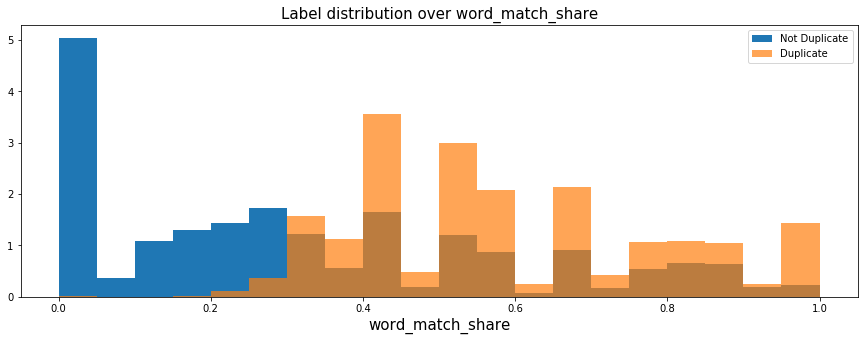

In [9]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

# TF-IDF

Now we are trying to improve this feature, by using something called TF-IDF (Term-Frequency Inverse Document Frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than the common words. This makes sense, for example, we care more about whether the word "exercise" appears in both the questions than the word "and", as uncommon words will be more indicative of the content.

In [10]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [11]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 9.72185765256025e-06), ('what', 1.1548410938654841e-05), ('is', 1.310272536687631e-05), ('how', 1.552843256001739e-05), ('i', 1.5868230216283978e-05), ('a', 1.6202466015327532e-05), ('to', 1.6492397004980703e-05), ('in', 1.7221782110012743e-05), ('of', 2.031075454453133e-05), ('do', 2.0627062706270627e-05)]

Least common words and weights: 


[('sugar,', 9.998000399920016e-05),
 ('geologist?', 9.998000399920016e-05),
 ('reject?', 9.998000399920016e-05),
 ('f-14', 9.998000399920016e-05),
 ('maul', 9.998000399920016e-05),
 ('gmail.', 9.998000399920016e-05),
 ("quickbooks'", 9.998000399920016e-05),
 ('jehovah', 9.998000399920016e-05),
 ('surathkal?', 9.998000399920016e-05),
 ('busy?', 9.998000399920016e-05)]

In [12]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'word_match_share')

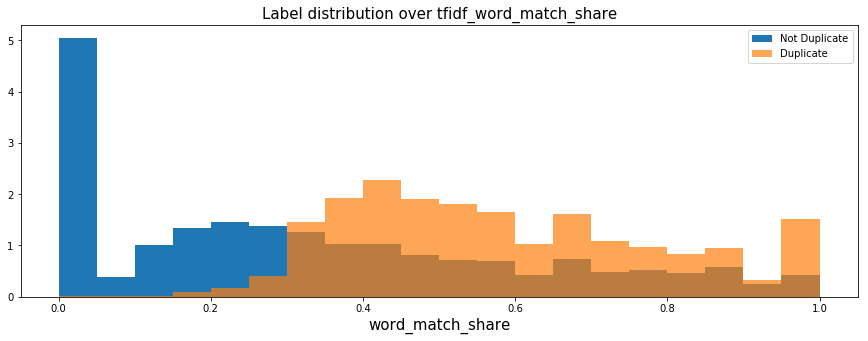

In [13]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [14]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7817758765181996
   TFIDF AUC: 0.7703942593595995


So, it looks like our TF-IDF actually got worse in terms of overall AUC, which is a bit disappointing. In the present assignment, we have used the AUC metric as it is unaffected by scaling implying it to be a good metric for testing the predictive power of individual features. 

# Rebalancing the Data

Before fitting the model, rebalancing of the data has been done as we have 37% positive class in our training data and only 17% in the test data. By re-balancing the data, such that our training set has 17% positives, we can ensure that XGBoost output probabilities will better match the data on the leaderboard and give us a better score (since LogLoss looks at the probabilities themselves and not just the order of the predictions like AUC).

In [15]:
x_train = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
y_train = df_train['is_duplicate'].values

In [16]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19094823167606356


In [17]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

# XG Boost

Now, we can finally run XG Boost on our data, in order to see the score on the leaderboard.

In [18]:
x_train.head()

,word_match,tfidf_word_match
3596,0.00,0.000000
21370,0.40,0.406289
24656,0.80,0.806157
87703,0.50,0.411801
21461,0.25,0.291232


In [19]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 10

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.688061	valid-logloss:0.688019
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.641491	valid-logloss:0.642057
[20]	train-logloss:0.602879	valid-logloss:0.603849
[30]	train-logloss:0.570236	valid-logloss:0.571711
[40]	train-logloss:0.542479	valid-logloss:0.544403
[50]	train-logloss:0.518807	valid-logloss:0.521066
[60]	train-logloss:0.498375	valid-logloss:0.500973
[70]	train-logloss:0.480722	valid-logloss:0.483615
[80]	train-logloss:0.465253	valid-logloss:0.468539
[90]	train-logloss:0.451832	valid-logloss:0.455364
[100]	train-logloss:0.440017	valid-logloss:0.443836
[110]	train-logloss:0.429515	valid-logloss:0.433734
[120]	train-logloss:0.420329	valid-logloss:0.424859
[130]	train-logloss:0.412288	valid-logloss:0.417034
[140]	train-logloss:0.405078	valid-logloss:0.410134
[150]	train-logloss:0.398634	valid-logloss:0.404046
[160]	train-logloss:0.393003

In [43]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

In [44]:
for i in range(len(p_test)):
    if p_test[i]>0.5:
        p_test[i] = 1
    else:
        p_test[i] = 0

In [45]:
roc_auc_score(p_test,y_test)

0.7056112654944408

In [46]:
from sklearn.metrics import classification_report

In [48]:
print(classification_report(p_test,y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     37915
         1.0       0.09      0.59      0.15      1105

   micro avg       0.81      0.81      0.81     39020
   macro avg       0.54      0.71      0.52     39020
weighted avg       0.96      0.81      0.87     39020



# Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rf = RandomForestClassifier(n_estimators=500)
x_train.fillna(0,inplace=True)
x_test.fillna(0,inplace=True)

In [51]:
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
preds = rf.predict(x_test)

In [53]:
for i in range(len(preds)):
    if preds[i]>0.5:
        preds[i] = 1
    else:
        preds[i] = 0

In [54]:
roc_auc_score(preds,y_test)

0.7966638158891866

In [56]:
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     33408
         1.0       0.52      0.70      0.60      5612

   micro avg       0.86      0.86      0.86     39020
   macro avg       0.73      0.80      0.76     39020
weighted avg       0.89      0.86      0.87     39020



# Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [58]:
cf = DecisionTreeClassifier()

In [59]:
cf.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [60]:
preds = cf.predict(x_test)

In [61]:
for i in range(len(preds)):
    if preds[i]>0.5:
        preds[i] = 1
    else:
        preds[i] = 0

In [62]:
roc_auc_score(preds,y_test)

0.7985771897095969

In [63]:
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     33449
         1.0       0.52      0.71      0.60      5571

   micro avg       0.87      0.87      0.87     39020
   macro avg       0.73      0.80      0.76     39020
weighted avg       0.89      0.87      0.87     39020



# Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
lr = LogisticRegression()

In [66]:
lr.fit(x_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [78]:
preds = lr.predict(x_test)

In [68]:
for i in range(len(preds)):
    if preds[i]>0.5:
        preds[i] = 1
    else:
        preds[i] = 0

In [69]:
roc_auc_score(preds,y_test)

0.6082764002002962

In [70]:
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88     36506
         1.0       0.13      0.40      0.20      2514

   micro avg       0.79      0.79      0.79     39020
   macro avg       0.54      0.61      0.54     39020
weighted avg       0.90      0.79      0.84     39020

